# 预处理
* node weight (name weight)
* node interaction (source	target	interaction	directed	symbol	value)

In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
import hicstraw
from sklearn.isotonic import IsotonicRegression
# font_manager.fontManager.ttflist.append(font_manager.FontProperties(fname='/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf'))
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
RNA=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg.txt",sep='\t')


In [2]:
name='NPC'
EP=pd.read_csv(f'/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/midata/filtered_{name}_chip.bedpe',sep='\t',header=None)
GBM.columns=['chr1','start1','end1','chr2','start2','end2','chr_g','start_g','end_g','gene','chr_e','start_e','end_e','samples','occurrences','unknown']

NameError: name 'GBM' is not defined

#### 添加weight

In [3]:
GBMmatrix=cooler.Cooler(f'/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/10000/{name}_merge_10000.cool')
# GBM 不用_merge_ 

In [4]:
from joblib import Parallel, delayed
# 没有flanking region
def fetch_contacts(row,bala=False):
    matrix = GBMmatrix.matrix(balance=bala).fetch(
        f'{row["chr1"]}:{row["start1"]}-{row["end1"]}',
        f'{row["chr2"]}:{row["start2"]}-{row["end2"]}'
    )
    if matrix.size == 1:
        return matrix.item()  # 返回标量值
    elif matrix.size == 0:
        return None  # 空数组返回 None
    else:
        print(f'Warning: {row["loopid"]} has more than one value')
        return matrix.mean()  

In [5]:

GBM['loopid'] = GBM['chr1'] + ':' + GBM['start1'].astype(str) + '-' + GBM['end1'].astype(str) + '_' + GBM['chr2'] + ':' + GBM['start2'].astype(str) + '-' + GBM['end2'].astype(str)
EP_loop=GBM.loc[:,['loopid','chr1','start1','end1','chr2','start2','end2']].drop_duplicates()

In [7]:
notna_indices = GBM_loop['loopid'].notna()
GBM_loop.loc[notna_indices, 'ICEcontact'] = Parallel(n_jobs=-1)(
    delayed(fetch_contacts)(row,bala=True) for _, row in GBM_loop.loc[notna_indices].iterrows()
)
# GBM_loop.loc[notna_indices, 'rawcontact'] = Parallel(n_jobs=-1)(
#     delayed(fetch_contacts)(row,bala=False) for _, row in GBM_loop.loc[notna_indices].iterrows()
# )
GBM_loop.to_csv(f'{name}_loop.txt',sep='\t',index=False)

In [8]:
# GBM_loop=pd.read_csv('GBM_loop.txt',sep='\t')
GBM=pd.merge(GBM,GBM_loop[['loopid','rawcontact','ICEcontact']],on='loopid')
GBM.drop(columns=['loopid'],inplace=True)

In [9]:
GBM.head()

,chr1,start1,end1,chr2,start2,end2,chr_g,start_g,end_g,gene,chr_e,start_e,end_e,samples,occurrences,unknown,rawcontact,ICEcontact
0,chr1,2410000,2420000,chr1,2540000,2550000,chr1,2413796,2413797,PEX10,chr1,2546333,2550019,NPC,1,Gene,86.0,0.026747
1,chr1,2410000,2420000,chr1,2540000,2550000,chr1,2413796,2413797,PEX10,chr1,2538717,2546199,NPC,1,Gene,86.0,0.026747
2,chr1,2580000,2590000,chr1,3440000,3450000,chr1,2581559,2581560,RP3-395M20.9,chr1,3440484,3442854,NPC,1,Gene,9.0,0.001557
3,chr1,2580000,2590000,chr1,3440000,3450000,chr1,2586490,2586491,PRXL2B,chr1,3440484,3442854,NPC,1,Gene,9.0,0.001557
4,chr1,3060000,3070000,chr1,3280000,3290000,chr1,3068436,3068437,PRDM16-DT,chr1,3282851,3283316,NPC,1,Gene,60.0,0.014408


#### 确定enhancer节点

In [10]:
fil1 = (GBM['chr1'] == GBM['chr_e']) & (GBM['start1'] <= GBM['end_e']) & (GBM['end1'] >= GBM['start_e'])
fil2 = (GBM['chr2'] == GBM['chr_e']) & (GBM['start2'] <= GBM['end_e']) & (GBM['end2'] >= GBM['start_e'])

GBM.loc[:,'ebin']=np.nan
GBM['ebin'] = GBM['ebin'].astype('object')
GBM.loc[fil1, 'ebin'] = GBM.loc[fil1, ['chr1', 'start1', 'end1']].astype(str).agg('_'.join, axis=1)
GBM.loc[fil2, 'ebin'] = GBM.loc[fil2, ['chr2', 'start2', 'end2']].astype(str).agg('_'.join, axis=1)

#### 节点矩阵和互作矩阵

In [11]:
GRN=GBM.loc[:,['gene','ebin','rawcontact','ICEcontact']].drop_duplicates()
# loop中会有重复的E-G作用
Eweights=GBM[['chr_e','start_e','end_e','ebin','occurrences']].drop_duplicates().groupby('ebin')['occurrences'].sum().reset_index()
Eweights['weights'] = np.log2(Eweights['occurrences'] + 1).transform(lambda x: (x - x.mean()) / x.std())

In [20]:


# Eweights=pd.read_csv('Eweights.txt',sep='\t')
# GRN=pd.read_csv('GRN.txt',sep='\t')

# Gweights=pd.read_csv("./Gweights.txt",sep='\t')
# GBM=pd.read_csv("./GBM.txt",sep='\t')
# Nweights=pd.read_csv('Nweights.txt',sep='\t')

In [16]:
RNA=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg.txt",sep='\t')
Gweights=GBM[['gene']].drop_duplicates()
Gweights=pd.merge(Gweights,RNA[['Gene',name]],left_on='gene',right_on='Gene',how='left')
Gweights.drop(columns=['Gene'],inplace=True)
Gweights['weights'] = np.log2(Gweights[name] + 1).transform(lambda x: (x - x.mean()) / x.std())

In [17]:

Nweights = pd.concat([Gweights[['gene', 'weights']], Eweights[['ebin', 'weights']].rename(columns={'ebin': 'gene'})])
Nweights.columns=['node','weights']

In [18]:
# interaction	directed	symbol
GRN['interaction'] = 'dd'
GRN['directed'] = 'TRUE'
GRN['symbol'] = [str(x) for x in range(1, GRN.shape[0] + 1)]
GRN=GRN.loc[:,['ebin','gene','interaction','directed','symbol','rawcontact','ICEcontact']]
GRN.columns=['node1','node2','interaction','directed','symbol','rawcontact','ICEcontact']

In [19]:
GRN.to_csv('GRN.txt',sep='\t',index=False)
Eweights.to_csv('Eweights.txt',sep='\t',index=False)
Gweights.to_csv('Gweights.txt',sep='\t',index=False)
Nweights.to_csv('Nweights.txt',sep='\t',index=False)
GBM.to_csv(f'{name}.txt',sep='\t',index=False)


#### 数据展示

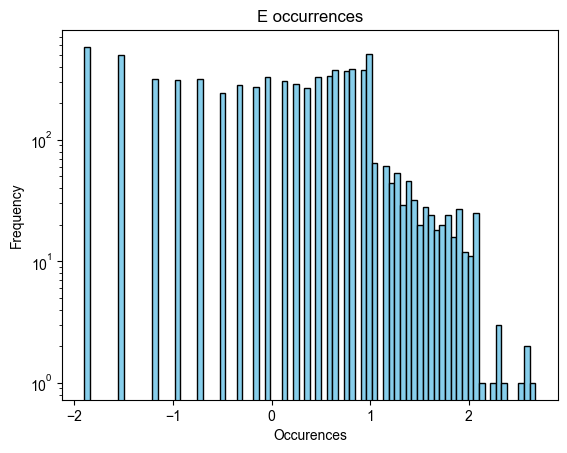

In [18]:
plt.hist(Eweights['weights'], bins=80, color='skyblue', edgecolor='black')  # bins为分组数
plt.yscale('log')
plt.title('E occurrences')  # 图标题
plt.xlabel('Occurences')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
plt.show()

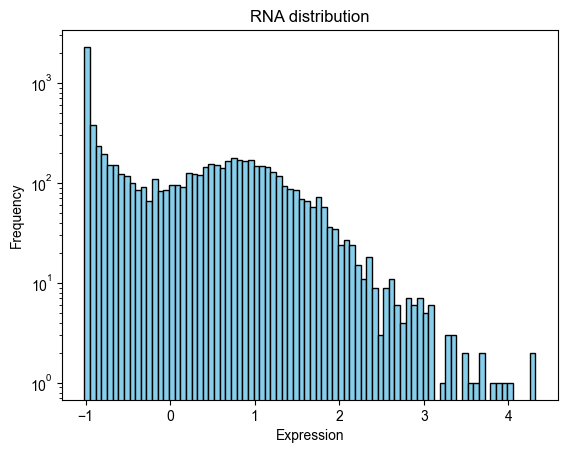

In [13]:
plt.hist(Gweights['weights'], bins=80, color='skyblue', edgecolor='black')  # bins为分组数
plt.yscale('log')
plt.title('RNA distribution')  # 图标题
plt.xlabel('Expression')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
plt.show()

# 数据展示  
* Enhancer 数量 
* E-P P-P other 数量    
* 各种 E-P 的基因表达


In [7]:
EP=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/cytoscape/loop_anno.bedpe',sep='\t',header=None)
EP.columns=['chr1','start1','end1','chr2','start2','end2','cloop','chr_g','start_g','end_g','ensembl','symbol','type','chr_e','start_e','end_e','samples','occurrences']

In [8]:
# get E-G pairs
# ebin 
fil1 = (EP['chr1'] == EP['chr_e']) & (EP['start1'] <= EP['end_e']) & (EP['end1'] >= EP['start_e'])
fil2 = (EP['chr2'] == EP['chr_e']) & (EP['start2'] <= EP['end_e']) & (EP['end2'] >= EP['start_e'])
EP.loc[:,'ebin']=np.nan
EP['ebin'] = EP['ebin'].astype('object')
EP['ebin_id'] = np.nan
EP['ebin_id'] = EP['ebin_id'].astype('object')
EP.loc[fil1, 'ebin'] = EP.loc[fil1, ['chr1', 'start1', 'end1']].astype(str).agg('_'.join, axis=1)
EP.loc[fil1,'ebin_id']=1
EP.loc[fil2, 'ebin'] = EP.loc[fil2, ['chr2', 'start2', 'end2']].astype(str).agg('_'.join, axis=1)
EP.loc[fil2,'ebin_id']=2

In [9]:
# gene
fil1 = (EP['chr1'] == EP['chr_g']) & (EP['start1'] <= EP['start_g']) & (EP['end1'] >= EP['end_g'])
fil2 = (EP['chr2'] == EP['chr_g']) & (EP['start2'] <= EP['start_g']) & (EP['end2'] >= EP['end_g'])
EP.loc[:,'gbin_id']=np.nan
EP['gbin_id'] = EP['gbin_id'].astype('object')
EP.loc[fil1,'gbin_id']=1
EP.loc[fil2,'gbin_id']=2

# 分类loop并给基因分类

In [6]:
EPs=EP.drop(columns=['ensembl','samples','chr_g','start_g','end_g','chr_e','start_e','end_e'])
EPs['Eweights'] = EPs.groupby('ebin')['occurrences'].transform('sum')

In [7]:
# 计算每个ebin分组中Eweights的唯一值数量
unique_counts = EPs.groupby('ebin')['Eweights'].nunique()

# 检查是否有分组的Eweights不是唯一的
if (unique_counts > 1).any():
    print("存在同一组的Eweights不相同的情况")
else:
    print("所有同一组的Eweights都是相同的")

所有同一组的Eweights都是相同的


In [3]:
# EPs.to_csv('EPs.txt',sep='\t',index=False)
EPs=pd.read_csv('EPs.txt',sep='\t')

In [4]:
EPss=EPs.drop(columns=['occurrences']).drop_duplicates()

In [10]:
EPss['loopid']=EPss['chr1'] + ':' + EPss['start1'].astype(str) + '-' + EPss['end1'].astype(str) + '_' + EPss['chr2'] + ':' + EPss['start2'].astype(str) + '-' + EPss['end2'].astype(str)
EPs['loopid']=EPs['chr1'] + ':' + EPs['start1'].astype(str) + '-' + EPs['end1'].astype(str) + '_' + EPs['chr2'] + ':' + EPs['start2'].astype(str) + '-' + EPs['end2'].astype(str)
EP['loopid']=EP['chr1'] + ':' + EP['start1'].astype(str) + '-' + EP['end1'].astype(str) + '_' + EP['chr2'] + ':' + EP['start2'].astype(str) + '-' + EP['end2'].astype(str)

In [11]:
EP.loc[EP['loopid']=='chrY:6950000-6980000_chrY:7860000-7890000',:]

,chr1,start1,end1,chr2,start2,end2,cloop,chr_g,start_g,end_g,...,type,chr_e,start_e,end_e,samples,occurrences,ebin,ebin_id,gbin_id,loopid
110212,chrY,6950000,6980000,chrY,7860000,7890000,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY:6950000-6980000_chrY:7860000-7890000


In [12]:
# 存在同一个loop，两端是不同的基因
EPss.groupby('loopid')['gbin_id'].nunique().value_counts()

gbin_id
1    8472
2    5089
0    4866
Name: count, dtype: int64

In [ ]:
# 看看全都是NA的loop anchor
all_na_groups = EPss.groupby('loopid')['gbin_id'].apply(lambda x: x.isna().all())
num_all_na_groups = all_na_groups.sum()

print(num_all_na_groups)
# 4866

4866


In [14]:
unique_counts = EPss.groupby('loopid')['gbin_id'].nunique()
# 同一个loop有两个基因ID的loop
difuni = unique_counts[unique_counts == 2].index

EPss.loc[EPss['loopid'].isin(difuni),:]

,chr1,start1,end1,chr2,start2,end2,cloop,symbol,type,ebin,ebin_id,gbin_id,Eweights,loopid
34,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT-DT,lncRNA,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6230000-6260000_chr1:6420000-6450000
38,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT-DT,lncRNA,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6230000-6260000_chr1:6420000-6450000
40,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT,protein_coding,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6230000-6260000_chr1:6420000-6450000
44,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT,protein_coding,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6230000-6260000_chr1:6420000-6450000
46,chr1,6230000,6260000,chr1,6420000,6450000,3,HES3,protein_coding,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6230000-6260000_chr1:6420000-6450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110256,chrY,19720000,19750000,chrY,20560000,20590000,3,KDM5DP1,processed_pseudogene,chrY_20560000_20590000,2.0,2.0,44.0,chrY:19720000-19750000_chrY:20560000-20590000
110257,chrY,19720000,19750000,chrY,20560000,20590000,3,TTTY10,lncRNA,chrY_19720000_19750000,1.0,2.0,25.0,chrY:19720000-19750000_chrY:20560000-20590000
110258,chrY,19720000,19750000,chrY,20560000,20590000,3,TTTY10,lncRNA,chrY_20560000_20590000,2.0,2.0,44.0,chrY:19720000-19750000_chrY:20560000-20590000
110259,chrY,19720000,19750000,chrY,20560000,20590000,3,EIF1AY,protein_coding,chrY_19720000_19750000,1.0,2.0,25.0,chrY:19720000-19750000_chrY:20560000-20590000


In [15]:
EPss['looptype']=np.nan
EPss['looptype'] = EPss['looptype'].astype('object')
# E-P loop
EPss.loc[EPss['gbin_id'].notna() & EPss['ebin_id'].notna() & EPss['gbin_id']!=EPss['ebin_id'],'looptype']='E-P'
# EPss

In [16]:
EPss['looptype'].value_counts()

looptype
E-P    35099
Name: count, dtype: int64

In [48]:


def analyze_loop_interactions(df):
    """
    分析loop中的真实相互作用关系
    
    Parameters:
    df: DataFrame, 包含以下列:
        - loopid: loop的唯一标识符
        - enhancer_pos: Enhancer在loopanchor的位置 (1, 2)
        - gene_pos: 基因在loopanchor的位置 (1, 2)
    
    Returns:
    DataFrame: 包含每个loop的完整互作信息
    """
    # 创建一个字典来存储每个loop的信息
    loop_info = {}
    
    for _, row in df.iterrows():
        loopid = row['loopid']
        # 初始化loop信息
        if loopid not in loop_info:
            loop_info[loopid] = {
                'ebin_id': set(),
                'gbin_id': set()
            }
        e_pos = row['ebin_id']
        g_pos = row['gbin_id']
        
        # 添加位置信息
        if not pd.isna(e_pos):
            loop_info[loopid]['ebin_id'].add(str(e_pos))
        if not pd.isna(g_pos):
            loop_info[loopid]['gbin_id'].add(str(g_pos))
    
    # 分析每个loop的类型
    results = []
    for loopid, info in loop_info.items():
        enhancers = info['ebin_id']
        genes = info['gbin_id']
        
        # 确定loop类型
        is_ep = False
        is_pp = False
        is_ee = False
        is_other = False
        
        # 检查E-P相互作用
        if enhancers and genes:
            # 如果enhancer和gene在loop的不同端，就是E-P
            if len(enhancers.intersection(genes)) < len(enhancers.union(genes)):
                is_ep = True
        
        # 检查P-P相互作用
        if len(genes) >= 2:
            is_pp = True
            
        # 检查E-E相互作用
        if len(enhancers) >= 2:
            is_ee = True
            
        # 如果都不是，标记为other
        if not any([is_ep, is_pp, is_ee]):
            is_other = True
            
        results.append({
            'loopid': loopid,
            'E-P': is_ep,
            'P-P': is_pp,
            'E-E': is_ee,
            'other': is_other,
            'ebin_id': ','.join(sorted(enhancers)),
            'gbin_id': ','.join(sorted(genes))
        })
    
    return pd.DataFrame(results)

def get_gene_loop_types(df, gene_column):
    """
    分析每个基因参与的loop类型
    
    Parameters:
    df: DataFrame, 包含loop分析结果和基因信息
    gene_column: 字符串，基因列的名称
    
    Returns:
    DataFrame: 包含每个基因参与的loop类型统计
    """
    # 创建基因-loop类型统计表
    unique_genes = df[gene_column].unique()
    
    stats = []
    for gene in unique_genes:
        gene_loops = df[df[gene_column] == gene]
        
        stat = {
            'gene': gene,
            'E-P_loops': gene_loops['E-P'].sum(),
            'P-P_loops': gene_loops['P-P'].sum(),
            'E-E_loops': gene_loops['E-E'].sum(),
            'other_loops': gene_loops['other'].sum(),
            'total_loops': len(gene_loops),
            'unique_interactions': len(gene_loops['loopid'].unique())
        }
        stats.append(stat)
    
    return pd.DataFrame(stats)



In [49]:

if __name__ == "__main__":
    df=EPss
    
    # 分析loop互作
    loop_analysis = analyze_loop_interactions(df)
    
    # 合并原始数据的基因信息
    gene_info = df[['loopid', 'symbol']].drop_duplicates()
    result_df = pd.merge(loop_analysis, gene_info, on='loopid')
    
    # 获取每个基因的统计信息
    gene_stats = get_gene_loop_types(result_df, 'symbol')
    

In [50]:
result_df.head()

,loopid,E-P,P-P,E-E,other,ebin_id,gbin_id,symbol
0,chr1:2810000-2840000_chr1:3420000-3450000,True,False,True,False,"1.0,2.0",1.0,ENSG00000233234
1,chr1:2810000-2840000_chr1:3420000-3450000,True,False,True,False,"1.0,2.0",1.0,ENSG00000287396
2,chr1:2810000-2840000_chr1:3420000-3450000,True,False,True,False,"1.0,2.0",1.0,ENSG00000231630
3,chr1:2990000-3020000_chr1:3410000-3440000,False,False,True,False,"1.0,2.0",,NaN
4,chr1:3900000-3930000_chr1:5730000-5760000,True,False,True,False,"1.0,2.0",1.0,C1orf174


In [51]:
gene_stats.head()

,gene,E-P_loops,P-P_loops,E-E_loops,other_loops,total_loops,unique_interactions
0,ENSG00000233234,1,0,1,0,1,1
1,ENSG00000287396,1,0,1,0,1,1
2,ENSG00000231630,1,0,1,0,1,1
3,NaN,0,0,0,0,0,0
4,C1orf174,1,0,1,0,1,1


In [53]:
result_df['symbol'].isna().sum()

4866